<a href="https://colab.research.google.com/github/UQROO-MarianaJetzuvelyGarciaHau/Colab-Tareas/blob/main/Proyecto_con_Platyplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparación e Instalación**

In [ ]:
# Instalar la biblioteca Platypus
!pip install platypus-opt

import pandas as pd
import os
from platypus import NSGAII, Problem, Integer
import numpy as np
import matplotlib.pyplot as plt

**Descarga y Análisis de Datos**

In [ ]:
#Cargar el archivo de datos
file_id = 'sample_data/80128_prueba_kwh.csv'
df = pd.read_csv(file_id)

if not os.path.exists(file_id):
    raise FileNotFoundError(f"No encontré el archivo en {file_id}. Súbelo a Colab o ajusta file_id.")

# Mostrar las primeras filas y los tipos de datos para verificación
print("--- Primeras filas ---")
print(df.head)
print("\n--- Información del DataFrame ---")
print(df.info())

# Renombrar columnas para facilitar el uso
print("\n--- Renombrar las columnas---")
print(df.columns.tolist())
df.columns = ['irradiancia', 'velocidadviento', 'carga']


--- Primeras filas ---
<bound method NDFrame.head of       irradiancia  velocidadviento      carga
0           0.311              4.0  10.547120
1           0.000              3.2  10.264410
2           0.000              3.4   9.134468
3           0.000              3.2   2.892932
4           0.000              5.2   0.118024
...           ...              ...        ...
8755      867.000              3.0   8.849163
8756      860.000              2.5   1.315819
8757      341.000              2.4   8.520978
8758      766.000              2.3   9.738552
8759      607.000              2.2   6.834133

[8760 rows x 3 columns]>

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   irradiancia      8760 non-null   float64
 1   velocidadviento  8760 non-null   float64
 2   carga            8760 non-null   float6

**Cálculo de Energía Generada y Balance Energético**

Aplicaremos las fórmulas proporcionadas para calcular la energía generada por una sola unidad de cada tecnología y escribiremos las constantes.

In [ ]:
#Constantes------------------------------------------------

# Panel solar
AREA_PANEL = 1.6
EFICIENCIA_PANEL = 0.18

# Aerogenerador
RADIO_ROTOR = 20
COEFICIENTE_POTENCIA = 0.4
DENSIDAD_AIRE = 1.225

FACTOR_CONVERSION = 1000  # Para pasar de W a kW, o de J/s a kWh si se asume un periodo de 1h

AREA_ROTOR = np.pi * (RADIO_ROTOR**2) # Área del rotor A = pi * r²

# Cálculo de la energía generada por una UNIDAD de cada uno (en kWh)
# Energía Solar (kWh) por panel
df['energia_solar_unidad'] = (df['irradiancia'] * AREA_PANEL * EFICIENCIA_PANEL) / FACTOR_CONVERSION

# Energía Eólica (kWh) por aerogenerador
# La fórmula dada asume que la potencia (en W) se convierte a energía (kWh) en un periodo de 1 hora.
df['energia_eolica_unidad'] = (0.5 * DENSIDAD_AIRE * AREA_ROTOR * (df['velocidadviento']**3) * COEFICIENTE_POTENCIA) / FACTOR_CONVERSION

# Imprimimos los resultados
print("--- Energía generada por unidad (Primeras filas) ---")
print(df[['irradiancia', 'velocidadviento', 'carga', 'energia_solar_unidad', 'energia_eolica_unidad']].head())


--- Energía generada por unidad (Primeras filas) ---
   irradiancia  velocidadviento      carga  energia_solar_unidad  \
0        0.311              4.0  10.547120               0.00009   
1        0.000              3.2  10.264410               0.00000   
2        0.000              3.4   9.134468               0.00000   
3        0.000              3.2   2.892932               0.00000   
4        0.000              5.2   0.118024               0.00000   

   energia_eolica_unidad  
0              19.704069  
1              10.088483  
2              12.100761  
3              10.088483  
4              43.289840  


**Planteamiento del Problema de Optimización con Platypus**

El objetivo es encontrar el número de paneles solares y aerogeneradores que minimice el déficit energético total a lo largo de todo el periodo de datos.

In [ ]:
 # Almacenar las series de datos necesarias
E_SOL_UNIDAD = df['energia_solar_unidad'].values
E_EOL_UNIDAD = df['energia_eolica_unidad'].values
CARGA = df['carga'].values

# Definir la función objetivo (Multi-Objetivo)
def balance_energetico(vars):
  N_sol = vars[0] # Número de páneles
  N_eol = vars[1]  # Número de aerogeneradores

  # # Energía generada total en cada instante de tiempo
  generacion_total = (N_sol * E_SOL_UNIDAD) + (N_eol * E_EOL_UNIDAD)

  # OBJETIVO 1
  deficit_por_tiempo = CARGA - generacion_total #balance
  deficit_total = np.sum(np.maximum(0, deficit_por_tiempo))


  # OBJETIVO 2
  COSTO_PANEL = 320           # USD por panel
  COSTO_TURBINA = 42000       # USD por aerogenerador
  PRECIO_KWH_RESPALDO = 0.4
  ANIOS_PROYECTO = 20

  # Inversión Inicial (CAPEX)
  inversion_equip = (N_sol * COSTO_PANEL) + (N_eol * COSTO_TURBINA)

  # Operación/Respaldo (OPEX)
  gasto_Operacion = deficit_total * PRECIO_KWH_RESPALDO * ANIOS_PROYECTO

  # Minimizar el Costo Total de Propiedad (TCO)
  costo_total_proy = inversion_equip + gasto_Operacion

  return [costo_total_proy, deficit_total]

# Implementación del Problema con Platypus -------------------------
problem = Problem(2, 2)

# Definir los tipos de variables y sus límites
MAX_PANELS = 2000
MAX_AEROGENERADORES = 100
problem.types[:] = [
    Integer(1, MAX_PANELS),         # N_sol
    Integer(0, MAX_AEROGENERADORES)  # N_eol
]

# Asignar la función de evaluación al problema
problem.function = balance_energetico
problem.directions[:] = [Problem.MINIMIZE, Problem.MINIMIZE]

# Elegir y crear la instancia del algoritmo
algorithm = NSGAII(problem)

# Ejecutar la optimización
N_EVALUATIONS = 10000
print(f"\n Ejecutando el algoritmo NSGAII con {N_EVALUATIONS} evaluaciones... ")
algorithm.run(N_EVALUATIONS)

# Extraer y mostrar la mejor solución
best_solution = algorithm.result[0]
for solution in algorithm.result:
    if solution.objectives[0] < best_solution.objectives[0]:
        best_solution = solution

# Decodificar los binarios a enteros
Nu_Paneles = problem.types[0].decode(best_solution.variables[0])
Nu_eol = problem.types[1].decode(best_solution.variables[1])
def_fin = best_solution.objectives[0]

print("\n--- SOLUCIÓN ÓPTIMA (Mínimo Déficit) ---")
print(f"**Criterio de Optimización:** Mínimo Déficit Energético")
print(f" \nCantidad de Paneles: {Nu_Paneles}")
print(f"Cantidad de Aerogeneradores: {Nu_eol}")
print(f"Déficit Anual Restante: {def_fin:,.2f} kWh")




 Ejecutando el algoritmo NSGAII con 10000 evaluaciones... 

--- SOLUCIÓN ÓPTIMA (Mínimo Déficit) ---
**Criterio de Optimización:** Mínimo Déficit Energético
 
Cantidad de Paneles: 38
Cantidad de Aerogeneradores: 1
Déficit Anual Restante: 210,554.13 kWh


**Reporte detallado**

In [ ]:
#Constantes
COSTO_PANEL_REPORTE = 320
COSTO_TURBINA_REPORTE = 42000
PRECIO_KWH_RESPALDO_REPORTE = 0.4
ANIOS = 20

def generar_desglose_financiero(nombre_opcion, solucion):

    # Recuperación de Variables de Diseño
    n_solar = problem.types[0].decode(solucion.variables[0])
    n_wind = problem.types[1].decode(solucion.variables[1])

    # Recuperación de Resultados de Optimización
    deficit_anual_optimo = solucion.objectives[1]
    costo_tco_algoritmo = solucion.objectives[0]

    # Cálculo de Componentes de Costo (Desglose)
    costo_capital_inicial = (n_solar * COSTO_PANEL_REPORTE) + (n_wind * COSTO_TURBINA_REPORTE)
    costo_operacional_respaldo = deficit_anual_optimo * PRECIO_KWH_RESPALDO_REPORTE * ANIOS
    tco_verificado = costo_capital_inicial + costo_operacional_respaldo

    # --- IMPRESIÓN DEL REPORTE ---
    print(f"=== {nombre_opcion}: Análisis Financiero ===")

   # A. Detalle de Diseño
    print(f"► Configuración del Sistema:")
    print(f"   - Paneles Solares: {n_solar} unidades")
    print(f"   - Aerogeneradores: {n_wind} unidades")
    print("-" * 35)

    # B. Desglose Financiero (CAPEX y OPEX)
    print(f"► Desglose de Costos por {ANIOS} Años:")
    print(f"   - **Inversión Inicial (CAPEX):** ${costo_capital_inicial:,.2f} USD")
    print(f"   - **Costo de Respaldo (OPEX):** ${costo_operacional_respaldo:,.2f} USD")
    print("-" * 35)

    # C. Resumen de Desempeño
    print(f"► Indicadores Clave:")
    print(f"   - Déficit Energético Anual Promedio: {deficit_anual_optimo:,.2f} kWh")
    print(f"   - **Costo Total de Propiedad (TCO):** ${tco_verificado:,.2f} USD")
    print("=====================================================\n")


# Ordenamos por el Costo Total de Propiedad
soluciones_ordenadas_por_tco = sorted(algorithm.result, key=lambda s: s.objectives[0])

# Opciones a reportar:
# Opción 1
# Es el punto de la Frontera de Pareto con el Costo Total más bajo.
opcion_minimo_costo = soluciones_ordenadas_por_tco[0]

# Opción 2
# Es una solución a la mitad de la lista ordenada por TCO.
opcion_balanceada = soluciones_ordenadas_por_tco[len(soluciones_ordenadas_por_tco)//2]

# Opción 3
# Es el punto de la Frontera de Pareto con el Déficit más bajo (y el TCO más alto).
opcion_maxima_autosuficiencia = soluciones_ordenadas_por_tco[-1]


generar_desglose_financiero("Opción 1: Menor (TCO)", opcion_minimo_costo)
generar_desglose_financiero("Opción 2: Solución de Compromiso", opcion_balanceada)
generar_desglose_financiero("Opción 3: Máxima Autosuficiencia", opcion_maxima_autosuficiencia)

=== Opción 1: Menor (TCO): Análisis Financiero ===
► Configuración del Sistema:
   - Paneles Solares: 38 unidades
   - Aerogeneradores: 1 unidades
-----------------------------------
► Desglose de Costos por 20 Años:
   - **Inversión Inicial (CAPEX):** $54,160.00 USD
   - **Costo de Respaldo (OPEX):** $156,394.13 USD
-----------------------------------
► Indicadores Clave:
   - Déficit Energético Anual Promedio: 19,549.27 kWh
   - **Costo Total de Propiedad (TCO):** $210,554.13 USD

=== Opción 2: Solución de Compromiso: Análisis Financiero ===
► Configuración del Sistema:
   - Paneles Solares: 106 unidades
   - Aerogeneradores: 31 unidades
-----------------------------------
► Desglose de Costos por 20 Años:
   - **Inversión Inicial (CAPEX):** $1,335,920.00 USD
   - **Costo de Respaldo (OPEX):** $33,752.41 USD
-----------------------------------
► Indicadores Clave:
   - Déficit Energético Anual Promedio: 4,219.05 kWh
   - **Costo Total de Propiedad (TCO):** $1,369,672.41 USD

=== Opci

**Frontera de Pareto (GRÁFICA)**

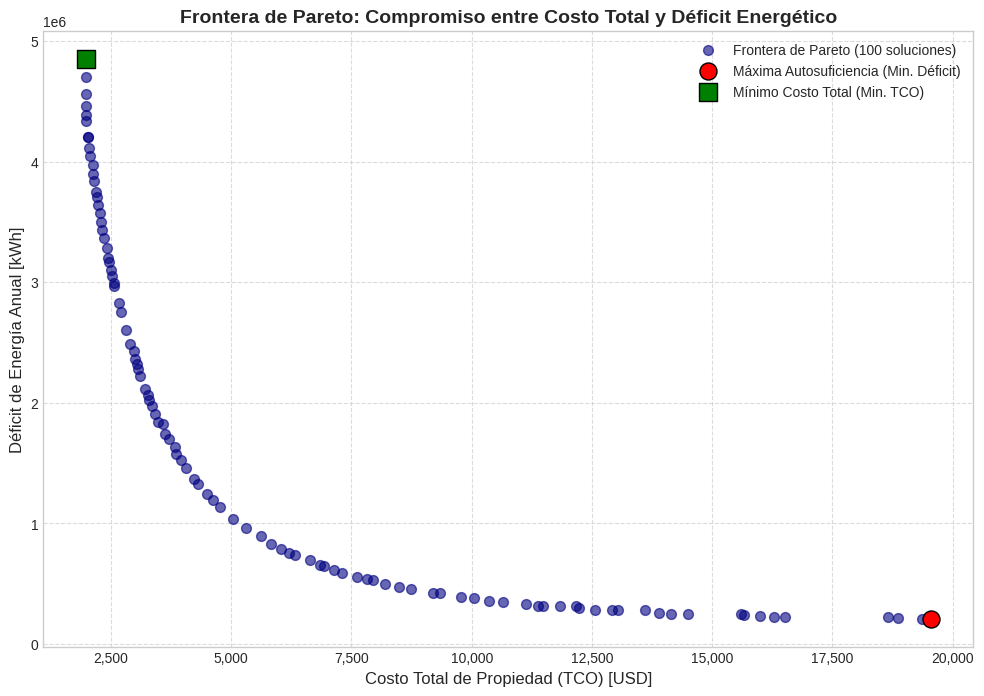

In [ ]:
# Extracción de datos y decodificación de soluciones clave
pareto_solutions = algorithm.result

# Extraemos los dos objetivos para la gráfica
# Déficit Total
deficits = [s.objectives[0] for s in pareto_solutions]
# Costo Total de Propiedad (TCO)
costos = [s.objectives[1] for s in pareto_solutions]

# Encontramos las soluciones extremas
solucion_min_deficit = sorted(pareto_solutions, key=lambda s: s.objectives[0])[0]
solucion_min_costo = sorted(pareto_solutions, key=lambda s: s.objectives[1])[0]

# Creación y Estilización de la Gráfica
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Trazar la Frontera de Pareto
plt.scatter(costos, deficits,
            c='navy',          # Color azul oscuro
            alpha=0.6,         # Transparencia
            s=50,              # Tamaño del marcador
            label=f'Frontera de Pareto ({len(pareto_solutions)} soluciones)')

# Resaltar la Solución de Mínimo Déficit (Máxima Autosuficiencia)
d_min = solucion_min_deficit.objectives[0]
c_as = solucion_min_deficit.objectives[1]
n_sol_as = solucion_min_deficit.variables[0]
n_eol_as = solucion_min_deficit.variables[1]

plt.scatter(c_as, d_min, c='red', marker='o', s=150, edgecolors='black', label='Máxima Autosuficiencia (Min. Déficit)')

# Resaltar la Solución de Mínimo Costo Total (TCO)
d_cost = solucion_min_costo.objectives[0]
c_min = solucion_min_costo.objectives[1]
n_sol_mc = solucion_min_costo.variables[0]
n_eol_mc = solucion_min_costo.variables[1]

plt.scatter(c_min, d_cost, c='green', marker='s', s=150, edgecolors='black', label='Mínimo Costo Total (Min. TCO)')
plt.title('Frontera de Pareto: Compromiso entre Costo Total y Déficit Energético', fontsize=14, fontweight='bold')
plt.xlabel('Costo Total de Propiedad (TCO) [USD]', fontsize=12)
plt.ylabel('Déficit de Energía Anual [kWh]', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Formato para que los números del eje X se vean bien (millares)
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, pos: f'{x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()